# Local bitcoin market prices

Data has been downloaded of multiple exchange rates of cryptocurrency markets. It is known that many cryptocurrencies mirror bitcoin. The objective of this section is to validate this.

Steps Taken
* Data is loaded into a dataframe named S2
* Using btcUSD as a reference, some exchanges are missing dates. Forward filling and backward filling are done to fill these NA's
* Outliers negatively impact analysis, thresholding these outliers to the upper 75% interquartile range alleviates this
* Linear regression is down on a training set without and with cross-validation.

In [85]:
import requests
import numpy as np
import pandas as pd
import datetime

from sklearn import linear_model, multioutput, preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

In [108]:
base_name_ = 'Bitcoin Markets (', ').csv'
local_tuple = ['localbtcUSD', 'localbtcCAD', 'localbtcSGD', 'localbtcHKD', 'localbtcMXN', 'localbtcNZD', 'localbtcPLN', 
               'localbtcRUB', 'localbtcTHB', 'localbtcARS', 'localbtcZAR', 'localbtcSEK', 'localbtcDKK', 'localbtcCZK', 
               'localbtcINR', 'localbtcILS', 'localbtcAUD', 'localbtcNOK', 'coincheckJPY', 'korbitKRW', 'coinfloorGBP', 
               'krakenEUR', 'btceEUR', 'bitcurexEUR']

#S2 = pd.DataFrame()
S2_btc = pd.read_csv('btc data/Bitcoin Markets (' + local_tuple[0] + ').csv', header=0)
S2_btc = S2_btc.rename( columns = {'Weighted Price': local_tuple[0]+'_weighted_price'})
S2_btc = S2_btc.assign(Date = pd.to_datetime(S2_btc['Date'], format='%Y-%m-%d'))
S2_btc = S2_btc.filter(regex=('Date|.*weighted_price'))
S2 = S2_btc.copy()

for coin_name in local_tuple[1:]:
    S2_tmp = pd.read_csv('btc data/Bitcoin Markets (' + coin_name + ').csv', header=0)
    S2_tmp = S2_tmp.rename( columns = {'Weighted Price': coin_name+'_weighted_price'})
    S2_tmp = S2_tmp.assign(Date = pd.to_datetime(S2_tmp['Date'], format='%Y-%m-%d'))
    S2_tmp = S2_tmp.filter(regex=('Date|.*weighted_price'))
    
    S2 = pd.merge(S2, S2_tmp, how="left", on=["Date"])
    
    S2_percent_check = pd.merge(S2_btc, S2_tmp, how="left", on=["Date"], indicator=True)
    percent_missing = len(S2_percent_check[S2_percent_check['_merge'] != 'both'])/S2_percent_check.shape[0]
    print("concatting coin", coin_name, "to S2. Percent missing compared to USD", percent_missing)

print("head of S2\n", S2.head())

concatting coin localbtcCAD to S2. Percent missing compared to USD 0.0005361930294906167
concatting coin localbtcSGD to S2. Percent missing compared to USD 0.006434316353887399
concatting coin localbtcHKD to S2. Percent missing compared to USD 0.012332439678284183
concatting coin localbtcMXN to S2. Percent missing compared to USD 0.0
concatting coin localbtcNZD to S2. Percent missing compared to USD 0.0010723860589812334
concatting coin localbtcPLN to S2. Percent missing compared to USD 0.05630026809651475
concatting coin localbtcRUB to S2. Percent missing compared to USD 0.009115281501340482
concatting coin localbtcTHB to S2. Percent missing compared to USD 0.007506702412868633
concatting coin localbtcARS to S2. Percent missing compared to USD 0.02091152815013405
concatting coin localbtcZAR to S2. Percent missing compared to USD 0.03967828418230563
concatting coin localbtcSEK to S2. Percent missing compared to USD 0.0005361930294906167
concatting coin localbtcDKK to S2. Percent missin

Lets look at the coin that has some missing dates - btcEUR

In [87]:
S2_eEUR = pd.read_csv('btc data/Bitcoin Markets (btceEUR).csv', header=0).filter(regex=('Date|Weighted Price'))
S2_eEUR = S2_eEUR.assign(Date = pd.to_datetime(S2_eEUR['Date'], format='%Y-%m-%d'))
print(S2_eEUR)
S2_eEUR =  pd.merge(S2_btc, S2_eEUR, how="left", on=["Date"], indicator=True)
print(S2_eEUR[S2_eEUR['_merge'] != 'both'])


           Date  Weighted Price
0    2017-07-25     2280.880616
1    2017-07-24     2282.503769
2    2017-07-23     2294.991623
3    2017-07-22     2298.793323
4    2017-07-21     2257.267719
5    2017-07-20     2186.283718
6    2017-07-19     2011.844966
7    2017-07-18     1987.160096
8    2017-07-17     1817.719044
9    2017-07-16     1669.819208
10   2017-07-15     1818.558922
11   2017-07-14     1960.641248
12   2017-07-13     2075.763960
13   2017-07-12     2072.863505
14   2017-07-11     2067.593843
15   2017-07-10     2139.474708
16   2017-07-09     2238.804693
17   2017-07-08     2211.931919
18   2017-07-07     2215.134023
19   2017-07-06     2266.472057
20   2017-07-05     2262.430442
21   2017-07-04     2284.292385
22   2017-07-03     2226.361805
23   2017-07-02     2130.099338
24   2017-07-01     2159.192693
25   2017-06-30     2196.653225
26   2017-06-29     2237.113505
27   2017-06-28     2213.262113
28   2017-06-27     2120.773598
29   2017-06-26     2161.525651
...     

For simplicity, will back fill and forward fill

In [109]:
S2 = S2.fillna(method='backfill').fillna(method='ffill')
S2 = S2.set_index('Date')

In [110]:
print(S2.isnull().sum())

localbtcUSD_weighted_price     0
localbtcCAD_weighted_price     0
localbtcSGD_weighted_price     0
localbtcHKD_weighted_price     0
localbtcMXN_weighted_price     0
localbtcNZD_weighted_price     0
localbtcPLN_weighted_price     0
localbtcRUB_weighted_price     0
localbtcTHB_weighted_price     0
localbtcARS_weighted_price     0
localbtcZAR_weighted_price     0
localbtcSEK_weighted_price     0
localbtcDKK_weighted_price     0
localbtcCZK_weighted_price     0
localbtcINR_weighted_price     0
localbtcILS_weighted_price     0
localbtcAUD_weighted_price     0
localbtcNOK_weighted_price     0
coincheckJPY_weighted_price    0
korbitKRW_weighted_price       0
coinfloorGBP_weighted_price    0
krakenEUR_weighted_price       0
btceEUR_weighted_price         0
bitcurexEUR_weighted_price     0
dtype: int64


Performance on raw data is pretty abysmal, thresholding outliers to the 75% interquartile range dramatically improves this

In [111]:
S2['localbtcUSD_weighted_price'] = S2['localbtcUSD_weighted_price'].clip_upper(S2['localbtcUSD_weighted_price'].quantile(0.95))

In [112]:
S2.head()

,localbtcUSD_weighted_price,localbtcCAD_weighted_price,localbtcSGD_weighted_price,localbtcHKD_weighted_price,localbtcMXN_weighted_price,localbtcNZD_weighted_price,localbtcPLN_weighted_price,localbtcRUB_weighted_price,localbtcTHB_weighted_price,localbtcARS_weighted_price,...,localbtcINR_weighted_price,localbtcILS_weighted_price,localbtcAUD_weighted_price,localbtcNOK_weighted_price,coincheckJPY_weighted_price,korbitKRW_weighted_price,coinfloorGBP_weighted_price,krakenEUR_weighted_price,btceEUR_weighted_price,bitcurexEUR_weighted_price
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-18,8363.533951,8483.463261,10024.306000,63047.175407,146080.496461,11240.067849,26244.928438,483042.954895,243033.885932,176639.756311,...,518273.252209,35149.652033,10428.853776,67957.486115,865230.468434,8.578665e+06,5692.943676,6533.499529,2280.880616,574.531011
2018-04-17,8226.619499,8560.636516,10452.797236,62754.033130,145754.546743,11395.764825,27280.851903,484694.266965,240894.072117,176762.356794,...,517938.562296,35776.777745,10707.011787,62777.513523,860585.306028,8.579731e+06,5653.115644,6496.544676,2280.880616,574.531011
2018-04-16,8336.985087,8861.132277,11137.795981,64330.700618,146633.781232,11450.027690,26466.279578,489529.873101,242679.455229,174787.850720,...,513387.847500,35920.746862,10688.969565,62196.990418,873489.219626,8.630642e+06,5654.170076,6546.620878,2280.880616,574.531011
2018-04-15,8812.433888,8575.436777,10827.553792,63290.323990,151301.575050,11144.159552,26888.328717,506175.536642,240125.884254,177700.765654,...,511167.111156,30125.642828,10910.137674,67590.625140,882272.321805,8.530623e+06,5842.976526,6705.439090,2280.880616,574.531011
2018-04-14,8042.016700,10151.050692,10425.383471,60002.438585,147723.893354,11085.610008,25914.145749,496019.876331,235925.638765,178436.344527,...,507771.748604,27035.910000,10463.227752,61340.758592,859805.306005,8.402306e+06,5679.508658,6504.105544,2280.880616,574.531011


## Linear Regression

Perform linear regression on determining 'localbtcUSD' with other bitcoin weighted prices.

In [113]:
Y = S2.loc[:,['localbtcUSD_weighted_price']]
X = S2.loc[:,~S2.columns.isin(Y)]
print("shape of X and Y", X.shape, Y.shape)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)

shape of X and Y (1865, 23) (1865, 1)


### Without Cross-validation

In [114]:
# linear regression with stanardization before fit
modelA = linear_model.LinearRegression()
modelA = modelA.fit(train_X, train_Y)
predicted_Y = modelA.predict(train_X)

In [115]:
print("weights\n", modelA.coef_[0])

weights
 [ 3.60844694e-01 -3.15150729e-01  3.33452715e-02 -2.94908043e-02
  2.97643433e-01  8.84337884e-03 -6.04740345e-03 -1.00391938e-02
  4.86192236e-02  2.80483831e-02  2.79839833e-02  2.88450199e-02
 -2.35607547e-03 -7.91699803e-03 -4.13215518e-03  5.33810840e-01
 -5.05814462e-02 -8.03658171e-03 -2.99517291e-05  9.26794285e-01
 -8.95750980e-02  9.68008235e-01 -2.93384770e-01]


In [116]:
print("Training score for linear regression:", modelA.score(train_X, train_Y))
print("Testing score for linear regression:", modelA.score(test_X, test_Y))

Training score for linear regression: 0.978105628623405
Testing score for linear regression: 0.9170328667416952


### With Cross-validation

In [119]:
lr = linear_model.LinearRegression()

predicted_cv = cross_val_predict(lr, train_X, train_Y, cv=10)
predicted_score = cross_val_score(lr, train_X, train_Y, cv=10)

In [120]:
predicted_score

array([0.96589899, 0.95950739, 0.97948107, 0.97768601, 0.98302342,
       0.98847969, 0.92501464, 0.97418892, 0.97171104, 0.96518063])

In [121]:
print("No cross-validation Y\n", predicted_Y, "\ncross-validation Y\n", predicted)

No cross-validation Y
 [[9411.92157998]
 [ 137.59869263]
 [  79.15570039]
 ...
 [ 300.44755248]
 [ 263.28458112]
 [ 181.12588919]] 
cross-validation Y
 [[1333.21892189]
 [ 560.81860965]
 [ 112.33626004]
 ...
 [ 493.95328049]
 [ 514.84978429]
 [ 368.7512054 ]]


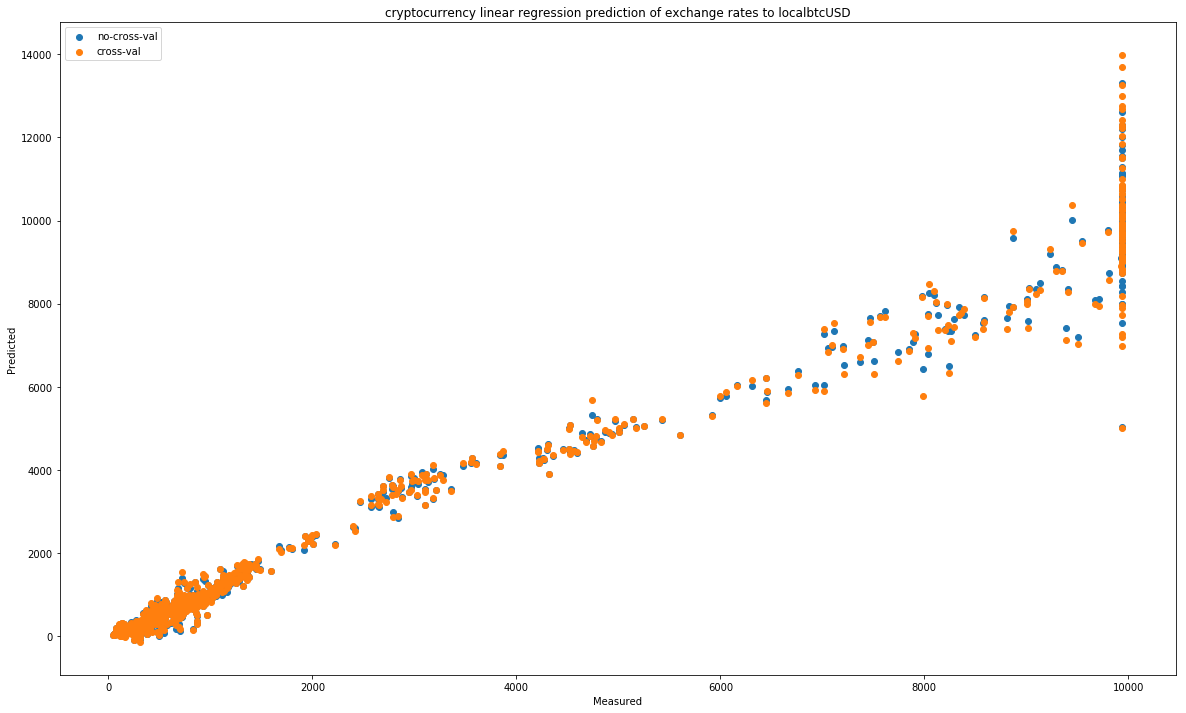

In [133]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(train_Y, predicted_Y, label="no-cross-val")
ax.scatter(train_Y, predicted_cv, label="cross-val")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend(loc='upper left')
ax.set_title('cryptocurrency linear regression prediction of exchange rates to localbtcUSD')
plt.show()